GBF - MAE: 78.87232596450472
GBF - MSE: 9611.18887912973
GBF - MAPE: 0.03133685282356905
Epoch 10, Loss: 8563486.0
Epoch 20, Loss: 8561980.0
Epoch 30, Loss: 8553029.0
Epoch 40, Loss: 8518976.0
Epoch 50, Loss: 8420147.0
Epoch 60, Loss: 8184682.0
Epoch 70, Loss: 7706451.5
Epoch 80, Loss: 6868169.5
Epoch 90, Loss: 5619680.5
Epoch 100, Loss: 4138123.25
CNN - MAE: 1907.234130859375
CNN - MSE: 4519188.5
CNN - MAPE: 0.6589788794517517


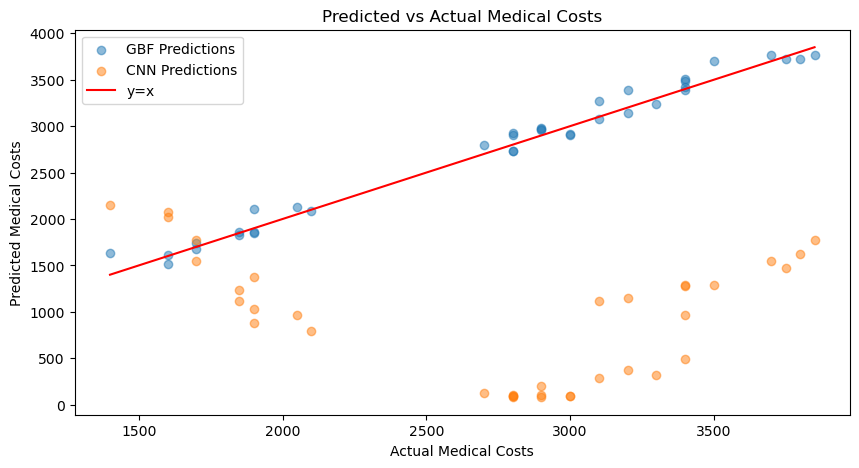

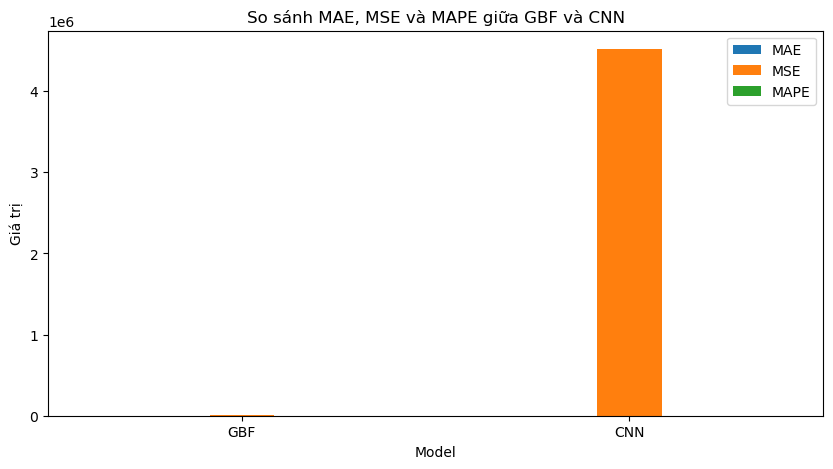

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('medical_cost_data.csv')

# X là các feature, y là cột Medical_Cost
X = data.drop('Medical_Cost', axis=1).values
y = data['Medical_Cost'].values

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia tập dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Chuyển đổi dữ liệu thành float32
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# --------------------------------------
# 1. Mô hình Gradient Boosted Forest (GBF)
# --------------------------------------

# Tạo và huấn luyện mô hình GBF
gbf_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbf_model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred_gbf = gbf_model.predict(X_test)

# Đánh giá GBF
mae_gbf = mean_absolute_error(y_test, y_pred_gbf)
mse_gbf = mean_squared_error(y_test, y_pred_gbf)
mape_gbf = mean_absolute_percentage_error(y_test, y_pred_gbf)

print(f"GBF - MAE: {mae_gbf}")
print(f"GBF - MSE: {mse_gbf}")
print(f"GBF - MAPE: {mape_gbf}")

# --------------------------------------
# 2. Mô hình CNN với TensorFlow thuần
# --------------------------------------

# Khởi tạo trọng số ngẫu nhiên
def init_weights(shape):
    return tf.Variable(tf.random.normal(shape, stddev=0.01, dtype=tf.float32))

# Tạo mô hình CNN bằng cách sử dụng TensorFlow thuần
class CNNModel:
    def __init__(self):
        self.W1 = init_weights([3, 1, 32])  # kernel 3, input 1, output 32 filters
        self.W2 = init_weights([3, 32, 64])
        self.W3 = init_weights([X_train.shape[1]*64, 128])  # Fully connected layer
        self.W4 = init_weights([128, 1])  # Output layer
    
    def model(self, X):
        X = tf.nn.conv1d(X, self.W1, stride=1, padding='SAME')
        X = tf.nn.relu(X)
        X = tf.nn.conv1d(X, self.W2, stride=1, padding='SAME')
        X = tf.nn.relu(X)
        X = tf.reshape(X, [-1, X_train.shape[1]*64])
        X = tf.nn.relu(tf.matmul(X, self.W3))
        return tf.matmul(X, self.W4)

# Chuyển đổi định dạng cho TensorFlow
X_train_cnn = np.expand_dims(X_train, axis=-1)
X_test_cnn = np.expand_dims(X_test, axis=-1)

# Tạo mô hình
cnn_model = CNNModel()

# Khai báo optimizer và loss function
optimizer = tf.optimizers.Adam(learning_rate=0.001)

# Training function
def train_step(X, y):
    with tf.GradientTape() as tape:
        predictions = cnn_model.model(X)
        loss = tf.reduce_mean(tf.square(y - predictions))  # Sử dụng squared_error loss
    gradients = tape.gradient(loss, [cnn_model.W1, cnn_model.W2, cnn_model.W3, cnn_model.W4])
    optimizer.apply_gradients(zip(gradients, [cnn_model.W1, cnn_model.W2, cnn_model.W3, cnn_model.W4]))
    return loss

# Huấn luyện mô hình CNN
epochs = 100
for epoch in range(epochs):
    loss = train_step(X_train_cnn, y_train.reshape(-1, 1))
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.numpy()}')

# Dự đoán với mô hình CNN
y_pred_cnn = cnn_model.model(X_test_cnn).numpy().flatten()

# Đánh giá CNN
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
mape_cnn = mean_absolute_percentage_error(y_test, y_pred_cnn)

print(f"CNN - MAE: {mae_cnn}")
print(f"CNN - MSE: {mse_cnn}")
print(f"CNN - MAPE: {mape_cnn}")

# --------------------------------------
# Vẽ biểu đồ kết quả
# --------------------------------------

# Biểu đồ Loss (GBF không có loss qua epochs nên bỏ qua)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_gbf, alpha=0.5, label='GBF Predictions')
plt.scatter(y_test, y_pred_cnn, alpha=0.5, label='CNN Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', label='y=x')
plt.title('Predicted vs Actual Medical Costs')
plt.xlabel('Actual Medical Costs')
plt.ylabel('Predicted Medical Costs')
plt.legend()
plt.show()
# --------------------------------------
# Vẽ biểu đồ so sánh MAE, MSE, MAPE giữa hai mô hình
# --------------------------------------

# Tạo một DataFrame chứa các chỉ số đánh giá
metrics = pd.DataFrame({
    'Model': ['GBF', 'CNN'],
    'MAE': [mae_gbf, mae_cnn],
    'MSE': [mse_gbf, mse_cnn],
    'MAPE': [mape_gbf, mape_cnn]
})

# Vẽ biểu đồ so sánh
metrics.set_index('Model', inplace=True)
metrics.plot(kind='bar', figsize=(10, 5))
plt.title('So sánh MAE, MSE và MAPE giữa GBF và CNN')
plt.ylabel('Giá trị')
plt.xticks(rotation=0)
plt.show()
